In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
try:
    data = pd.read_csv("/content/dataset.csv")
except FileNotFoundError:
    print("Error: FAOSTAT data file not found. Please provide the correct path.")
    exit()

In [ ]:
# More efficient data preprocessing
element_mapping = {
    "Emissions Share (CH4)": "Emissions_Share_CH4",
    "Emissions Share (CO2)": "Emissions_Share_CO2",
    "Emissions Share (CO2eq) (AR5)": "Emissions_Share_CO2eq_AR5",
    "Emissions Share (CO2eq) (AR5) (F-gases)": "Emissions_Share_CO2eq_AR5_F_gases",
    "Emissions Share (N2O)": "Emissions_Share_N2O",
    "Emissions per area of agricultural land": "Emissions_per_area",
    "Emissions per capita": "Emissions_per_capita",
    "Emissions per value of agricultural production": "Emissions_per_value",
}

In [ ]:
print(data.columns)

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')


In [ ]:
print(data.head())

  Domain Code                Domain  Area Code (M49)   Area  Element Code  \
0          EM  Emissions indicators              356  India        726313   
1          EM  Emissions indicators              356  India        726313   
2          EM  Emissions indicators              356  India        726313   
3          EM  Emissions indicators              356  India        726313   
4          EM  Emissions indicators              356  India        726313   

                         Element  Item Code       Item  Year Code  Year Unit  \
0  Emissions Share (CO2eq) (AR5)       6996  Farm gate       1990  1990    %   
1  Emissions Share (CO2eq) (AR5)       6996  Farm gate       1991  1991    %   
2  Emissions Share (CO2eq) (AR5)       6996  Farm gate       1992  1992    %   
3  Emissions Share (CO2eq) (AR5)       6996  Farm gate       1993  1993    %   
4  Emissions Share (CO2eq) (AR5)       6996  Farm gate       1994  1994    %   

   Value Flag Flag Description  
0  51.99    E  Estimate

In [ ]:
data = data.groupby(['Area', 'Year', 'Element'])['Value'].mean().unstack().reset_index()  # More efficient pivot
data.rename(columns=element_mapping, inplace=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
print(data)

Element   Area  Year  Emissions_Share_CH4  Emissions_Share_CO2  \
0        India  1990            41.741250            29.370833   
1        India  1991            41.655625            29.525833   
2        India  1992            41.632500            29.485833   
3        India  1993            41.785000            29.737500   
4        India  1994            41.705625            29.705833   
5        India  1995            41.503750            29.770000   
6        India  1996            41.460000            29.563333   
7        India  1997            41.231250            29.645833   
8        India  1998            41.246875            29.655833   
9        India  1999            41.107500            29.282500   
10       India  2000            41.029375            29.199167   
11       India  2001            40.987500            28.823333   
12       India  2002            40.828125            28.975833   
13       India  2003            40.655000            29.064167   
14       I

In [ ]:
# Convert numeric columns after renaming and dropping NaNs
numeric_cols = list(element_mapping.values())
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')  # More efficient numeric conversion
data.dropna(inplace=True) # Drop any new NaNs created from conversion.

In [ ]:
data['Total_Emissions_Share'] = data[[col for col in data.columns if col.startswith('Emissions_Share_')]].sum(axis=1)

In [ ]:
X = data.drop(["Emissions_per_area", 'Area', 'Year'], axis=1)
y = 1 / (data["Emissions_per_area"] + 1e-9)

In [ ]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [col for col in X.columns if col not in numerical_features]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'  # Handle any unexpected columns more robustly
)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.01601441381463e-05
R-squared: 0.9616051773071611


In [ ]:
# More efficient feature importance retrieval
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

In [ ]:
print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                                  Feature  Importance
5               num__Emissions_per_capita    0.259200
2          num__Emissions_Share_CO2eq_AR5    0.229881
6                num__Emissions_per_value    0.177096
0                num__Emissions_Share_CH4    0.139847
1                num__Emissions_Share_CO2    0.117038
4                num__Emissions_Share_N2O    0.045439
3  num__Emissions_Share_CO2eq_AR5_F_gases    0.020656
7              num__Total_Emissions_Share    0.010844


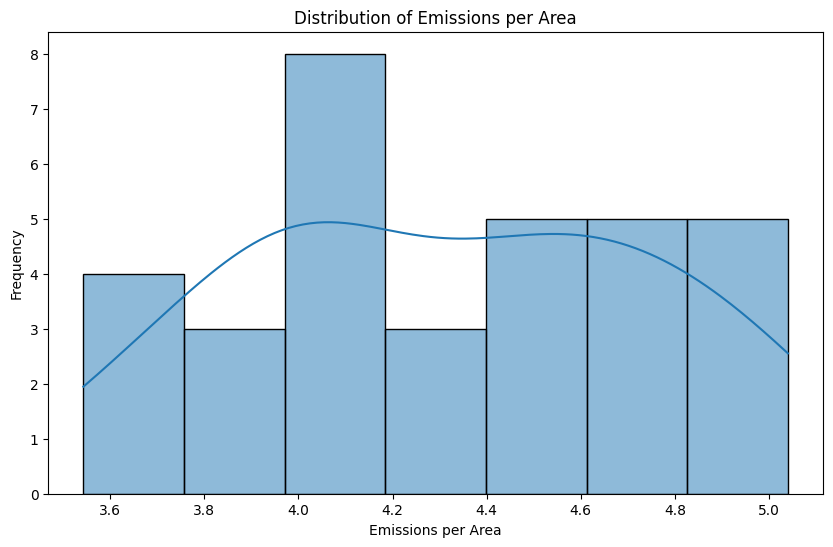

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data['Emissions_per_area'], kde=True)
plt.title('Distribution of Emissions per Area')
plt.xlabel('Emissions per Area')
plt.ylabel('Frequency')
plt.show()

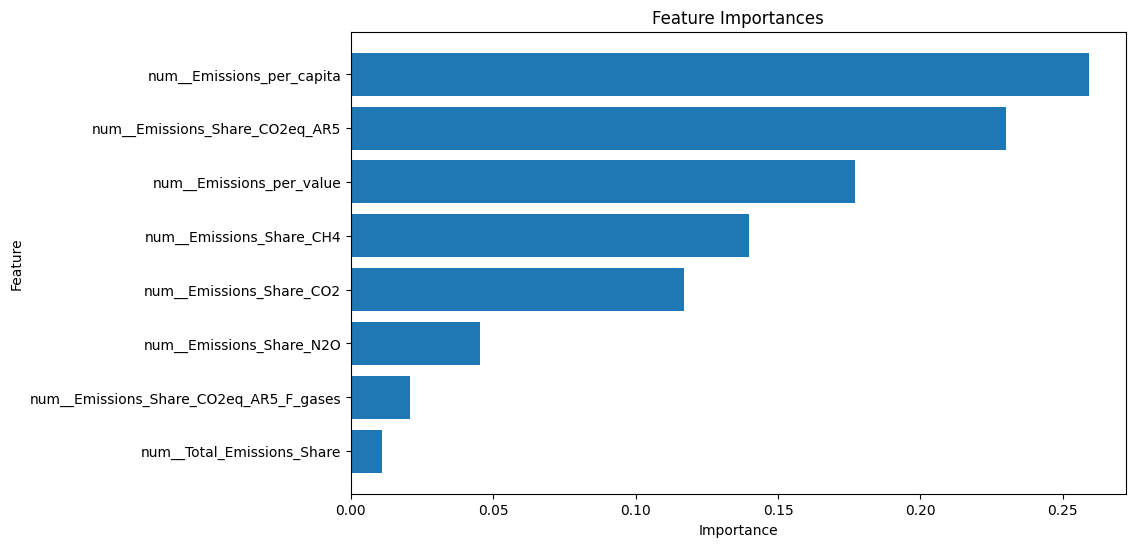

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

##Future Predicitions Sample

In [ ]:
future_data = pd.DataFrame({
    'Area': ['USA', 'Canada', 'Mexico'],
    'Year': [2025, 2025, 2025],
    'Emissions_Share_CH4': [8, 7, 9],
    'Emissions_Share_CO2': [45, 40, 55],
    'Emissions_Share_CO2eq_AR5': [55, 50, 65],
    'Emissions_Share_CO2eq_AR5_F_gases': [2, 1, 3],
    'Emissions_Share_N2O': [5, 4, 6],
    'Emissions_per_capita': [15, 14, 16],
    'Emissions_per_value': [10, 9, 11]
})

In [ ]:
future_data['Total_Emissions_Share'] = future_data[[col for col in future_data.columns if col.startswith('Emissions_Share_')]].sum(axis=1)

In [ ]:
X_future = future_data.drop(['Area', 'Year'], axis=1)

predictions = pipeline.predict(X_future)

X_future_transformed = pipeline.named_steps['preprocessor'].transform(X_future)
predictions = pipeline.named_steps['regressor'].predict(X_future_transformed)

In [ ]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
X_future_transformed = pd.DataFrame(X_future_transformed, columns=feature_names)

In [ ]:
future_predictions = pipeline.predict(X_future)
future_data['Predicted_Emissions_per_area'] = 1 / (future_predictions + 1e-9)

In [ ]:
print("\nFuture Predictions:")
print(future_data)


Future Predictions:
     Area  Year  Emissions_Share_CH4  Emissions_Share_CO2  \
0     USA  2025                    8                   45   
1  Canada  2025                    7                   40   
2  Mexico  2025                    9                   55   

   Emissions_Share_CO2eq_AR5  Emissions_Share_CO2eq_AR5_F_gases  \
0                         55                                  2   
1                         50                                  1   
2                         65                                  3   

   Emissions_Share_N2O  Emissions_per_capita  Emissions_per_value  \
0                    5                    15                   10   
1                    4                    14                    9   
2                    6                    16                   11   

   Total_Emissions_Share  Predicted_Emissions_per_area  
0                    115                      4.173838  
1                    102                      4.173838  
2                

In [ ]:
# Assuming 'baseline_emissions' is your defined baseline
baseline_emissions = 1.2

# 'future_data' from your notebook contains predictions
future_data['Emission_Reduction'] = baseline_emissions - future_data['Predicted_Emissions_per_area']

area_mapping = {
    'USA': 914742000,  # Example value in hectares
    'Canada': 909350700,  # Example value in hectares
    'Mexico': 197255000  # Example value in hectares
}
future_data['Area_in_hectares'] = future_data['Area'].map(area_mapping)


# Calculate carbon credits
future_data['Carbon_Credits'] = future_data['Emission_Reduction'] * future_data['Area_in_hectares']

print(future_data[['Area', 'Carbon_Credits']])

     Area  Carbon_Credits
0     USA   -2.720294e+09
1  Canada   -2.704261e+09
2  Mexico   -5.866043e+08
